# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **FAKEDDIT** by using pretrained **BERT** Embeddings, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter
import nltk 
import spacy
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

2022-07-01 00:09:13.317343: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-01 00:09:13.323065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-01 00:09:13.323083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Download

#### Loading the Full prepared dataset - Fakeddit cleaned data using nltk library on earlier works

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")

***
## 2. Dataset Cleaning and Preprocessing

#### Remove null values in the fulltext column

In [3]:
final_df=final_df.dropna()

In [19]:
final_df=final_df.reset_index(drop=True)

#### Create a copy of the dataframe

In [20]:
import copy
df=copy.deepcopy(final_df)

Create a new dataframe with two columns **fulltext and class**

In [21]:
df=df[['fulltext','class']]

##### Shuffling the rows and  filtering data around 50% 

In [22]:
fakeddit_df = df.sample(frac=.5)

###### Save the filtered data to csv format

In [24]:
fakeddit_df.to_csv("outputs//fakeddit_partial_data.csv",index=False)

***

## 3. Model Training and Evaluation

### BERT Embeddings

Next step is extract features from the news text column using pretrained BERT embeddings model


###### Create a pandas series dataframe which consists only fulltext column values

In [ ]:
texts=fakeddit_df['fulltext']

##### Download the Pretrained BERT embedding preprocessor and encoder  model from tensorflow hub

In [ ]:
# bert preprocessor - https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# bert encoder - https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2",trainable=True)

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.
Since our dataset is huge and it is not possible to transform full data to numeric token ids , we can do the same by splitting the data into multiple chunks as like below

**1st set** 

Create a first chunk of text series dataframe with first 10000 rows and then preprocess it using bert preprocessor

3 outputs from the preprocessing will be generated that a BERT model would use **(input_words_id, input_mask and input_type_ids)**.

Then encode the output and convert it into bert model features which can be feed to the model

In [ ]:
# preprocessing dataset  - First Set
inputs = preprocessor(texts[0:10000])
# feeding it to model for vectorization
outputs = encoder(inputs)



The above output BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. 
- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. 
- encoder_outputs are the intermediate activations of the L Transformer block


In [ ]:
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].

Then convert bert encoder sequence outputs to 1 dimension  and save the encoder sequence output to a dataframe for a single chunk.This same process need to do for all the splitted data chunks and then need to merge all the dataframes into a single one , which will feed to the model training

In [ ]:
# defining dataframe
bertf_df1=pd.DataFrame()

## Converting bert encoder sequence output to 1 dimension for ML Model training

for i in range(0,len(sequence_output)):
    b=sequence_output[i].numpy().sum(axis=0)
    bertf_df1=bertf_df1.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

bertf_df1.to_csv('outputs//fakeddit_ml_bertf_df1.csv', index=False)

##### 2nd Set

In [ ]:
# preprocessing dataset  - First Set
inputs2 = preprocessor(texts[10000:20000])
# feeding it to model for vectorization
outputs2 = encoder(inputs2)

pooled_output2 = outputs2["pooled_output"]      # [batch_size, 512].
sequence_output2 = outputs2["sequence_output"]  # [batch_size, seq_length, 512].

# defining dataframe
bertf_df2=pd.DataFrame()

## Converting bert encoder sequence output to 1 dimension for ML Model training

for i in range(0,len(sequence_output2)):
    b=sequence_output2[i].numpy().sum(axis=0)
    bertf_df2=bertf_df2.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

bertf_df2.to_csv('outputs//fakeddit_ml_bertf_df2.csv', index=False)

We have generated Bert embeddings in 24 sets like as above and saved those 24 csv files in a sperate folder named **Splitted_Bert_embeddings**

In [9]:
bertf_df1 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df1.csv")
bertf_df2 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df2.csv")
bertf_df3 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df3.csv")
bertf_df4 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df4.csv")
bertf_df5 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df5.csv")
bertf_df6 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df6.csv")
bertf_df7 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df7.csv")
bertf_df8 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df8.csv")
bertf_df9 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df9.csv")
bertf_df10 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df10.csv")
bertf_df11 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df11.csv")
bertf_df12 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df12.csv")
bertf_df13 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df13.csv")
bertf_df14 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df14.csv")
bertf_df15 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df15.csv")
bertf_df16 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df16.csv")
bertf_df17 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df17.csv")
bertf_df18 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df18.csv")
bertf_df19 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df19.csv")
bertf_df20 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df20.csv")
bertf_df21 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df21.csv")
bertf_df22 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df22.csv")
bertf_df23 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df23.csv")
bertf_df24 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df24.csv")
#bertf_df25 = pd.read_csv("outputs/fakeddit_ml_bert/Splitted_Bert_embeddings//fakeddit_ml_bertf_df25.csv")

#### Combining all the 24 sets into a single dataframe.

In [10]:
# merging both props 
bertVectors_fulldf=pd.concat([bertf_df1,bertf_df2,bertf_df3,bertf_df4,bertf_df5,bertf_df6,bertf_df7,bertf_df8,bertf_df9,
                              bertf_df10,bertf_df11,bertf_df12,bertf_df13,bertf_df14,bertf_df15,bertf_df16,bertf_df17,
                              bertf_df18,bertf_df19,bertf_df20,bertf_df21,bertf_df22,bertf_df23,bertf_df24])
bertVectors_fulldf.reset_index(drop=True,inplace=True)

In [11]:
bertVectors_fulldf.shape

(239806, 512)

#### Then add class label column in the merged bert feature dataframe and then this dataframe will go with train-test data splitting

In [ ]:
bertVectors_fulldf.insert(len(bertVectors_fulldf.columns),'class',fakeddit_df['class'])

#### Saving the combined bert features dataframe to csv 

In [12]:
bertVectors_fulldf.to_csv("outputs/fakeddit_ml_bert//bertVectors_fulldf_FAKEDDIT.csv",index=False)

#### Splitting dataset into features and class 

In [3]:
X=bertVectors_fulldf.drop('class',axis=1)
y=bertVectors_fulldf['class']

#### Using StratifiedKFold technique to create X_train , X_test, Y_train and Y_test

In [4]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [5]:
for i, j in kfold.split(X, y):
    # select rows
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [8]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [9]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***

### RandomForest


**Initialise the  model and  fit using train data and save it to a path**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)
rf_clf = rf_clf.fit(X_train, y_train)

# save the model to disk
filename = 'outputs//fakeddit_RF_bert.sav'
pickle.dump(rf_clf, open(filename, 'wb'))

print('RandomForest - Completed')

**Load the trained model to make predictions on the test data and measure the accuracy metrics**

In [11]:

#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_RF_bert.sav'

rf_model_loaded = pickle.load(open(filename, 'rb'))
result = rf_model_loaded.score(X_test, y_test)
print(result)


pred = rf_model_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8261087133295802
Accuracy score : 0.8261087133295802
Confusion matrix : 
 [[ 8159  6578]
 [ 1762 31462]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.55      0.66     14737
           1       0.83      0.95      0.88     33224

    accuracy                           0.83     47961
   macro avg       0.82      0.75      0.77     47961
weighted avg       0.83      0.83      0.82     47961

Precision : 0.8270767613038906
Recall : 0.9469660486395377
F1 Score : 0.8829703637180062


**Plot confusion matrix using the user defined functions created earlier**

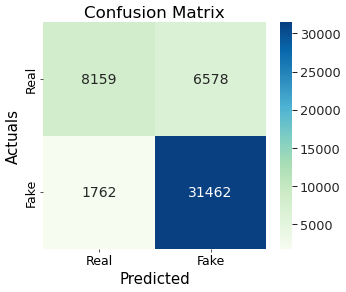

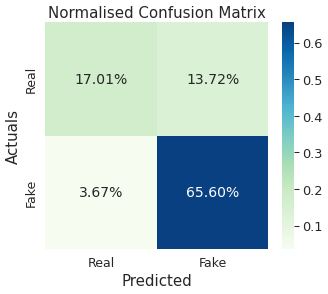

In [12]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_RF_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_RF_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### Support Vector Machine

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [55]:
svm_clf=SVC(random_state=0,probability=True)
svm_clf.fit(X_train, y_train)

filename = 'outputs//fakeddit_SVM_bert.sav'
pickle.dump(svm_clf, open(filename, 'wb'))

print('SVM - Completed')

In [13]:
#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_SVM_bert.sav'

svm_clf_loaded = pickle.load(open(filename, 'rb'))
result = svm_clf_loaded.score(X_test, y_test)
print(result)


pred = svm_clf_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8699568399324451
Accuracy score : 0.8699568399324451
Confusion matrix : 
 [[10882  3855]
 [ 2382 30842]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.74      0.78     14737
           1       0.89      0.93      0.91     33224

    accuracy                           0.87     47961
   macro avg       0.85      0.83      0.84     47961
weighted avg       0.87      0.87      0.87     47961

Precision : 0.8888952935412283
Recall : 0.9283048398747893
F1 Score : 0.9081727300834793


**Plot confusion matrix using the user defined functions created earlier**

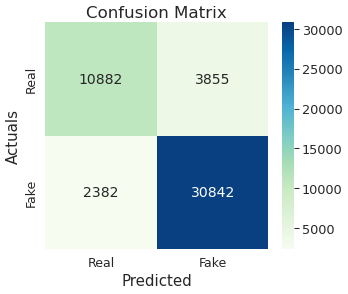

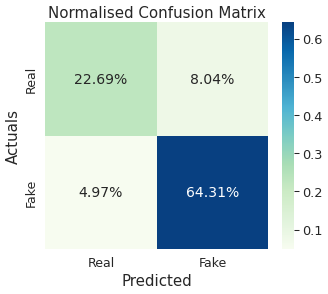

In [14]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_SVM_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_SVM_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### KNN

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [58]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

filename = 'outputs//fakeddit_KNN_bert.sav'
pickle.dump(knn_clf, open(filename, 'wb'))

print('KNN - Completed')

In [15]:
#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_KNN_bert.sav'

knn_clf_loaded = pickle.load(open(filename, 'rb'))
result = knn_clf_loaded.score(X_test, y_test)
print(result)


pred = knn_clf_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8095744459039637
Accuracy score : 0.8095744459039637
Confusion matrix : 
 [[10899  3838]
 [ 5295 27929]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.74      0.70     14737
           1       0.88      0.84      0.86     33224

    accuracy                           0.81     47961
   macro avg       0.78      0.79      0.78     47961
weighted avg       0.82      0.81      0.81     47961

Precision : 0.879182799760758
Recall : 0.840627257404286
F1 Score : 0.859472850086935


**Plot confusion matrix using the user defined functions created earlier**

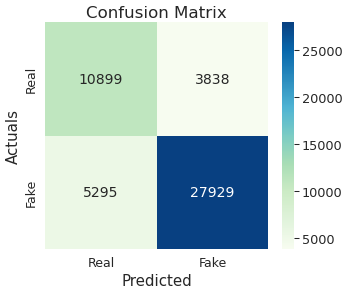

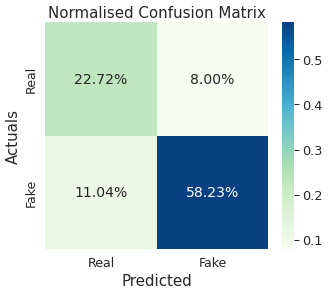

In [16]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_KNN_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_KNN_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### XgBoost

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [ ]:
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train,y_train)

filename = 'outputs//fakeddit_Xgboost_bert.sav'
pickle.dump(xg_clf, open(filename, 'wb'))

print('XgBoost - Completed')

In [17]:
#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_Xgboost_bert.sav'

xg_clf_loaded = pickle.load(open(filename, 'rb'))
result = xg_clf_loaded.score(X_test, y_test)
print(result)


pred = xg_clf_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.8455203185921895
Accuracy score : 0.8455203185921895
Confusion matrix : 
 [[10363  4374]
 [ 3035 30189]]
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.70      0.74     14737
           1       0.87      0.91      0.89     33224

    accuracy                           0.85     47961
   macro avg       0.82      0.81      0.81     47961
weighted avg       0.84      0.85      0.84     47961

Precision : 0.8734484853745335
Recall : 0.9086503732241753
F1 Score : 0.8907017569740511


**Plot confusion matrix using the user defined functions created earlier**

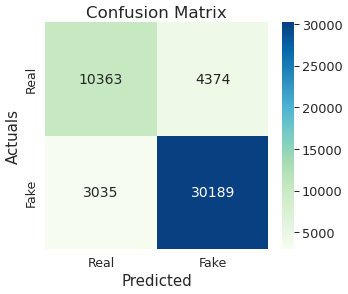

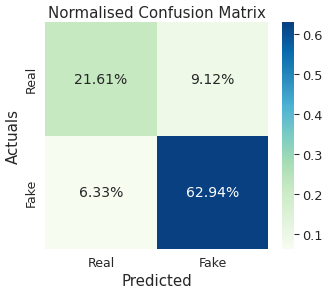

In [18]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_XGBoost_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_XGBoost_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### Naive Bayes

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
nb_clf.fit(X_train,y_train)

filename = 'outputs//fakeddit_NB_bert.sav'
pickle.dump(nb_clf, open(filename, 'wb'))

print('Naive - Completed')

In [19]:
#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_NB_bert.sav'

nb_clf_loaded = pickle.load(open(filename, 'rb'))
result = nb_clf_loaded.score(X_test, y_test)
print(result)


pred = nb_clf_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.5767185838493776
Accuracy score : 0.5767185838493776
Confusion matrix : 
 [[11290  3447]
 [16854 16370]]
Classification Report
              precision    recall  f1-score   support

           0       0.40      0.77      0.53     14737
           1       0.83      0.49      0.62     33224

    accuracy                           0.58     47961
   macro avg       0.61      0.63      0.57     47961
weighted avg       0.70      0.58      0.59     47961

Precision : 0.8260584346772972
Recall : 0.4927161088369853
F1 Score : 0.6172583473162271


**Plot confusion matrix using the user defined functions created earlier**

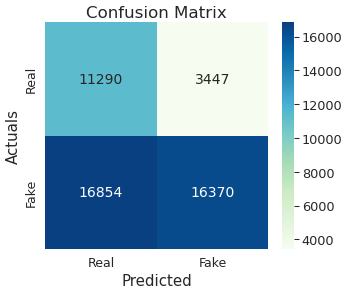

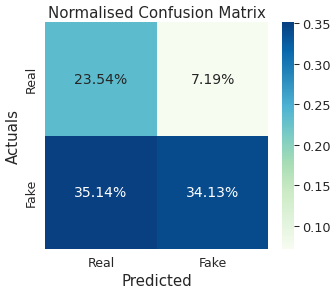

In [20]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_NB_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_NB_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### Logistic Regression

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [ ]:
from sklearn.linear_model import LogisticRegression

logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train,y_train)

filename = 'outputs//fakeddit_Logistic_bert.sav'
pickle.dump(logticreg_clf, open(filename, 'wb'))
print('LogisticRegression - Completed')


In [21]:
#Loading the model
filename = 'outputs//fakeddit_ml_bert//fakeddit_Logistic_bert.sav'

logistic_clf_loaded = pickle.load(open(filename, 'rb'))
result = logistic_clf_loaded.score(X_test, y_test)
print(result)


pred = logistic_clf_loaded.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

0.833969266695857
Accuracy score : 0.833969266695857
Confusion matrix : 
 [[ 9968  4769]
 [ 3194 30030]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.68      0.71     14737
           1       0.86      0.90      0.88     33224

    accuracy                           0.83     47961
   macro avg       0.81      0.79      0.80     47961
weighted avg       0.83      0.83      0.83     47961

Precision : 0.8629558320641397
Recall : 0.9038646761377318
F1 Score : 0.882936653778869


**Plot confusion matrix using the user defined functions created earlier**

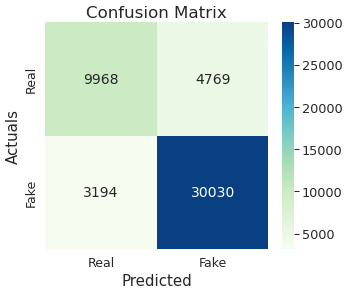

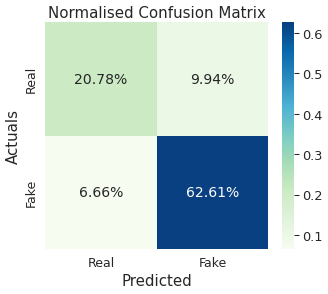

In [22]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_bert//fakeddit_ml_LR_bert_cmtrx.png"
path2="outputs//fakeddit_ml_bert//fakeddit_ml_LR_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot based on the scores of all the algorithms

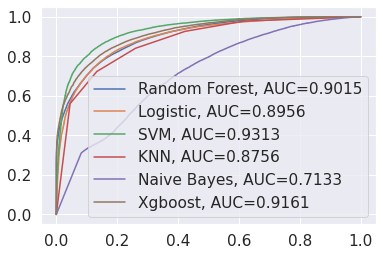

In [27]:
#set up plotting area
plt.figure(0).clf()

#fit RF model and plot ROC curve
y_pred = rf_model_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = logistic_clf_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_clf_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_clf_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_clf_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_loaded.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()